# Pandas post

## Introduction

El análisis de las carreteras se ha convertido en una tarea indispensable en las ciudades inteligentes. Tener un mayor conocimiento del tráfico permite una mejor organización y gobernanza de las vias. Los datos otorgados por sensonres en ciudades inteligentes suelen ser heterogéneos. En el caso de la ciudad de Madrid en España existen datos climáticos y de tráfico que cubren todo el centro de la ciudad. 

En este artículo utilizaremos estos datos que nos proporciona el ayuntamiento de madrid para hacer un análisis sobre el tráfico y las implicaciones de la meteorología en el tráfico de la ciudad.

## Datasets

Al tratar con Datasets heterogéneos la carga y acomodamiento de los datos se hará de forma independiente y luego se procederá a juntar estos datos en una sola tabla. Dividiremos esta sección en los datasets de tráfico y los de meteorología.

### Load Datasets

####  Weather

Los datos de meteorología se capturan de distintas localizaciones de la comunidad de Madrid. Se nos proporcionan en formato .csv, para descargarlos podemos añadirlos desde [Datos de tiempo](https://datos.madrid.es/portal/site/egob/menuitem.3efdb29b813ad8241e830cc2a8a409a0/?vgnextoid=4950cc720ba29610VgnVCM2000001f4a900aRCRD&vgnextchannel=102612b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default). Se utiliza pandas para cargar los archivos:

In [1]:
import csv 
import pandas as pd

weather = pd.read_csv('dic_meteo22.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

Los datos, tal como se muestra a continuación, tienen una columna magnitud que nos indica que tipo de datos meteorológicos nos muestra la fila:

    · 80: ULTRAVIOLETA
    · 81: VIENTO
    · 82: DIRECCION
    · 83: TEMPERATURA
    · 86: HUMEDAD
    · 87: PRESION
    · 88: SOLAR
    · 89: PRECIPITACION
    
Luego tenemos dos columnas por cada hora de forma que la primera nos indica el valor para el tipo de dato especificado por la columna magnitud y si el resultado es válido o no. Por último, tenemos columnas relacionadas con el tiempo y el lugar donde se hace la medición.

In [4]:
weather.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,108,81,28079108_81_98,2022,12,22,270.0,N,...,218.0,V,228.0,V,227.83,V,213.67,V,233.83,V
1,28,79,108,82,28079108_82_98,2022,12,22,9.0,N,...,10.0,V,10.0,V,9.00,V,9.00,V,8.00,V
2,28,79,108,83,28079108_83_98,2022,12,22,94.7,N,...,86.7,V,91.4,V,93.80,V,96.30,V,98.70,V
3,28,79,108,86,28079108_86_98,2022,12,22,1031.0,N,...,1031.0,V,1031.0,V,1031.00,V,1031.00,V,1031.00,V
4,28,79,108,87,28079108_87_98,2022,12,22,2.0,N,...,1.0,V,3.0,V,2.00,V,3.00,V,3.00,V


Además, para conectar el identificador de la estación meteorológica con las coordenadas tenemos otra tabla:

In [2]:
weather_station = pd.read_csv('Estaciones_control_datos_meteorologicos.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='latin-1')

#### Traffic

Los datos de tráfico se encuentran en los semáforos de la ciudad de madrid. Estos datos se componen de varias medidas de la situación de la via. Estas medidas se codensan en la medida "carga" (un porcentaje que mide la congestión). Se carga de la misma manera que la anterior tabla:

In [3]:
traffic = pd.read_csv('12-2022.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()

Podemos ver que además de las medidas de tráfico hay una columna fecha y otra id que servirán para unir con el resto de tablas en función de la localización y el tiempo:

In [12]:
traffic.head()

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2022-12-01 00:00:00,M30,3240,9.0,0,59.0,N,5
1,1001,2022-12-01 00:15:00,M30,3240,9.0,0,59.0,N,5
2,1001,2022-12-01 00:30:00,M30,300,1.0,0,66.0,N,5
3,1001,2022-12-01 00:45:00,M30,300,1.0,0,66.0,N,5
4,1001,2022-12-01 01:00:00,M30,300,1.0,0,66.0,N,5


Por último, se carga la tabla que relaciona los sensores de tráficos (determinados por la columna id de la tabla anterior) con la localización exacta del sensor.

In [4]:
traffic_station = pd.read_csv('pmed_ubicacion_12-2022.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

### Cleaning Datasets

#### Weather

En el dataset del clima tenemos la fecha separada en día, mes y año, pero en tráfico están todos estos datos juntos. Es por esto que se agruparán las columnas.

In [5]:
weather = weather.rename(columns={"ANO": "year", "MES": "month", "DIA":"day", "MAGNITUD":"magnitud", "ESTACION":"weather_station"})
weather["date"] = pd.to_datetime(weather[["year", "month", "day"]])

El siguiente paso será el transformar en filas independientes las columnas del valor y su validez por hora:

In [6]:
import re
weather_hour = weather.melt(id_vars=["weather_station", "magnitud", "date"],
                            value_vars=[x for x in weather.columns if re.match("^H", x)],
                            var_name="hour")

weather_valid = weather.melt( value_vars=[x for x in weather.columns if re.match("^V", x)], var_name="valid")

Ahora se pueden eliminar las mediciones no válidas:

In [7]:
weather= weather_hour[weather_valid["value"] == "V"].reset_index()

Ahora para asemejarlo a la tabla de tráfico se puede añadir la hora junto a la fecha:

In [8]:
weather["hour"] = weather["hour"].str[1:]
weather["hour"] = pd.to_timedelta(weather['hour'].astype(int)-1, unit='h')
weather["date"] = weather["date"] + weather["hour"]

Ahora podemos separar las distintas métricas:

In [9]:
weather_values = weather.assign(MAGNITUD = weather["magnitud"].map({80:"ultraviolet",
                                                             81:"wind",
                                                             82:"direction",
                                                             83:"temperature",
                                                             86:"humidity",
                                                             87:"pressure",
                                                             88:"solar",
                                                             89:"rainfall"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") 

In [10]:
# Unirlo a la anterior tabla
weather = pd.concat([weather, weather_values], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.drop(["index", "hour", "magnitud", "value"], axis=1).groupby([ "date", "weather_station"]).sum().reset_index()

#### Traffic

En primer lugar se eliminan las filas donde la toma de datos haya tenido algún error para ello filtramos los valores sin fallos en la medición. En la documentación nos dicen que estos valores se les representa con una "N".

In [11]:
# Quitar datos con errores
traffic= traffic[traffic["error"] == "N"]

Otras modificaciones que se han hecho son cambiar a un formato adecuado la columna fecha y eliminar las columnas que no hacen falta para el análisis.

In [12]:
# String a fecha
traffic['date'] = pd.to_datetime(traffic['fecha'], errors='coerce')
# Eliminar columnas innecesarias
traffic.drop(["tipo_elem", "error", "periodo_integracion", "fecha", "intensidad", "ocupacion", "vmed"], axis=1, inplace=True)

Por último como las mediciones de los sensores se toman cada 15 minutos, agrupamos los valores por cada hora y calculamos la media. De esta forma los tiempos de tráfico y de meteorología se encuentran en el mismo ..rango..

In [14]:
traffic = traffic.groupby([pd.Grouper(key="date", freq='1H'), 'id']).mean().rename(columns={"carga":"load"})

### Location

Para juntar las dos anteriores tablas necesitamos saber que sensores de tráfico se corresponden con las estaciones meteorológicas. Para ello se puede utilizar una matriz de distancias y encontrar los pares más cercanos.

In [168]:
# Calculo de distancias de sensores meteo y trafico
import numpy as np

weather_station = weather_station.rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
traffic_station = traffic_station.rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})

Se puede medir esta distancia directamente con las coordenadas. Pero para que queden más claras las distancias se utilizará la distancia haversine que calcula la distancia en metros entre un par de coordenadas:

In [169]:
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist

unit = Unit.KILOMETERS 
distance_matrix = haversine_vector(weather_station[["Latitude", "Longitude"]], traffic_station[["Latitude", "Longitude"]], unit, comb=True)

Se pueden observar en el mapa de calor que estas distancias van de 0 a 20 km:

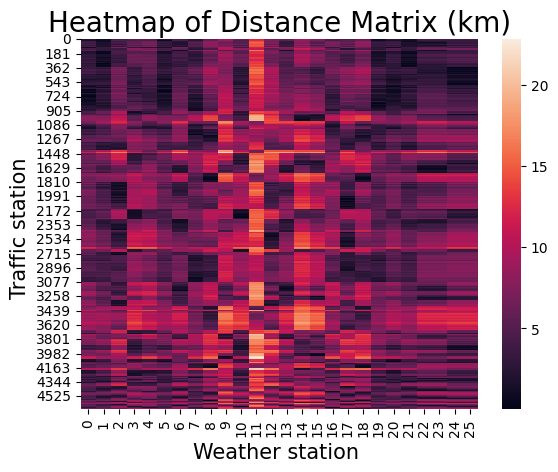

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
sns.heatmap(distance_matrix)
plt.title('Heatmap of Distance Matrix (km)', fontsize = 20) # title with fontsize 20
plt.xlabel('Weather station ', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Traffic station ', fontsize = 15) # y-axis label with fontsize 15
plt.show()

Se asociará el sensor de tráfico con el sensor meteorológico más cercano para evitar distancias largas entre ambos sensores.

In [ ]:
distance_table = pd.DataFrame.from_dict({'Distance': distance_matrix.argmin(axis=1), 'Closest':np.array(distance_matrix.min(axis=1), dtype=int)})
distance_table = distance_table.join(weather_station[["CÓDIGO_CORTO"]], on="Closest").rename(columns={"CÓDIGO_CORTO": 'weather_station'})
distance_table["id"] = distance_table.index

## Join datasets

In [16]:
# Juntar tiempo con distancias
complete = weather.merge(distance_table, on="weather_station")
# Juntar anterior con trafico
complete = complete.merge(traffic, on=["id", "date"])
# Renombra columna id por estacion_traf
complete.rename(columns={"id": 'traffic_station'}, inplace=True)
# Añadir dia de la semana y hora
complete["WEEKDAY"] = complete["date"].dt.weekday
complete["HOUR"] = complete["date"].dt.hour

In [17]:
complete

,date,weather_station,direction,humidity,pressure,rainfall,solar,temperature,wind,Distance,Closest,traffic_station,load,WEEKDAY,HOUR
0,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,1009,0.00,3,0
1,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,1010,0.00,3,0
2,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,1011,0.00,3,0
3,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,1012,0.00,3,0
4,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,14,0,1013,0.00,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841063,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,3858,2.75,5,23
841064,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,4609,7.50,5,23
841065,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,4610,3.25,5,23
841066,2022-12-31 23:00:00,35,0.0,61.0,0.0,0.0,0.0,10.7,0.0,3,5,4663,2.50,5,23


## Data interpretation

In [18]:
complete[["humidity", "direction", "pressure", "rainfall", "solar", "temperature", "wind"]].describe()

,humidity,direction,pressure,rainfall,solar,temperature,wind
count,841068.000000,841068.000000,841068.000000,841068.000000,841068.000000,841068.000000,841068.000000
mean,55.515464,13.026749,82.123552,0.013093,4.766577,9.834108,0.102401
std,42.427634,51.257697,266.564313,0.194232,33.287064,2.921133,0.425713
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.500000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,8.100000,0.000000
50%,79.000000,0.000000,0.000000,0.000000,0.000000,9.900000,0.000000
75%,93.000000,0.000000,0.000000,0.000000,0.000000,11.600000,0.000000
max,100.000000,358.000000,964.000000,10.900000,469.000000,20.700000,4.800000


Los días lectivos suelen tener más tráfico que los días festivos. Así como de día suele haber más tráfico que de noche. En la siguiente figura podemos comprobarlo. De lunes a viernes hay más tráfico y de 11 a 20 también. Vemos entonces que existe una fuerte estacionalidad en los datos.

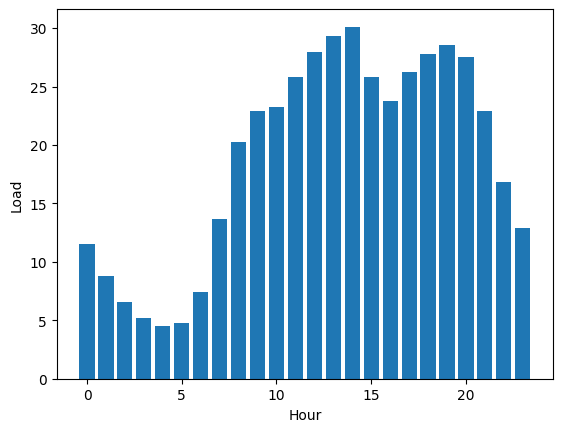

In [20]:
import matplotlib.pyplot as plt

load_per_hour = complete.groupby("HOUR")["load"].mean().values
plt.bar(np.arange(len(load_per_hour)), load_per_hour.reshape(-1))
plt.ylabel("Load")
plt.xlabel("Hour")
plt.show()

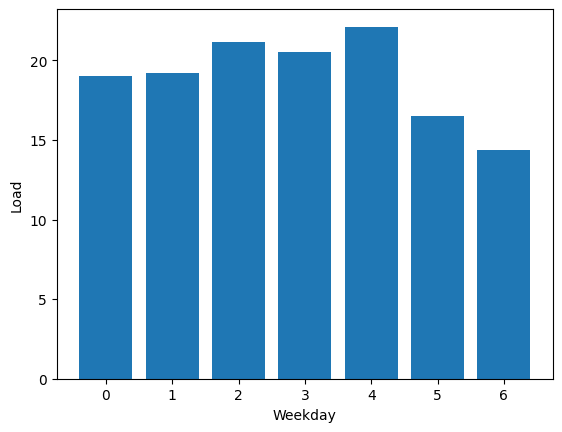

In [75]:
load_per_weekday = complete.groupby("WEEKDAY")["load"].mean().values
plt.bar(np.arange(len(load_per_weekday)), load_per_weekday.reshape(-1))
plt.ylabel("Load")
plt.xlabel("Weekday")
plt.show()

Como se puede comprobar los principales problemas de carga se dan entre las 10 a las 20 y de lunes a viernes.

La temperatura es otra variable altamente dependiente de la estacionalidad: las temperaturas son más bajas por la noche. Al solo tratar un mes la tendencia no se nota tanto. Podemos independizar la temperatura facilmente calculando la diferencia con la media por hora.

In [21]:
temps = complete.groupby(["HOUR", "WEEKDAY"])["temperature"].mean()
temps_avg = complete.index.map(lambda d: temps[complete.loc[d,"HOUR"],
                                                       complete.loc[d,"WEEKDAY"]
                                                       ])
complete["diff_temp"] = complete["temperature"] - temps_avg

Para completar esta sección, se crea una tabla donde se seleccionan las horas y días donde se dan más problemas de carga:

In [93]:
final = complete[(complete["WEEKDAY"]<5) & (complete["HOUR"]>9) & (complete["HOUR"]<20)].reset_index()

In [94]:
len(final), len(complete)

(253603, 841068)

Y las estaciones donde la media de la carga supere un umbral:

In [95]:
#final2 = final[final.groupby('date')['load'].transform('mean') >= 10]
final = final[final.groupby('traffic_station')['load'].transform('mean') >= 40]
len(final)

61843

Estudiemos la dependencia de las precepitaciones y la temperatura sobre la carga. Para ello se agrupan las columnas de carga y precipitación:

In [96]:
final["rainfall_m"] = pd.cut(final["rainfall"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])
final["load_m"] = pd.cut(final["load"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])

### Rainfall-Load dependency

Para estudiar la dependencia de la lluvia sobre la carga podemos estudiar la lluvia por horas para evitar la dependencia temporal de la carga. En el siguiente boxplot parece que en el caso de una lluvia fuerte parece que la carga en carretera tiene cierto aumento.

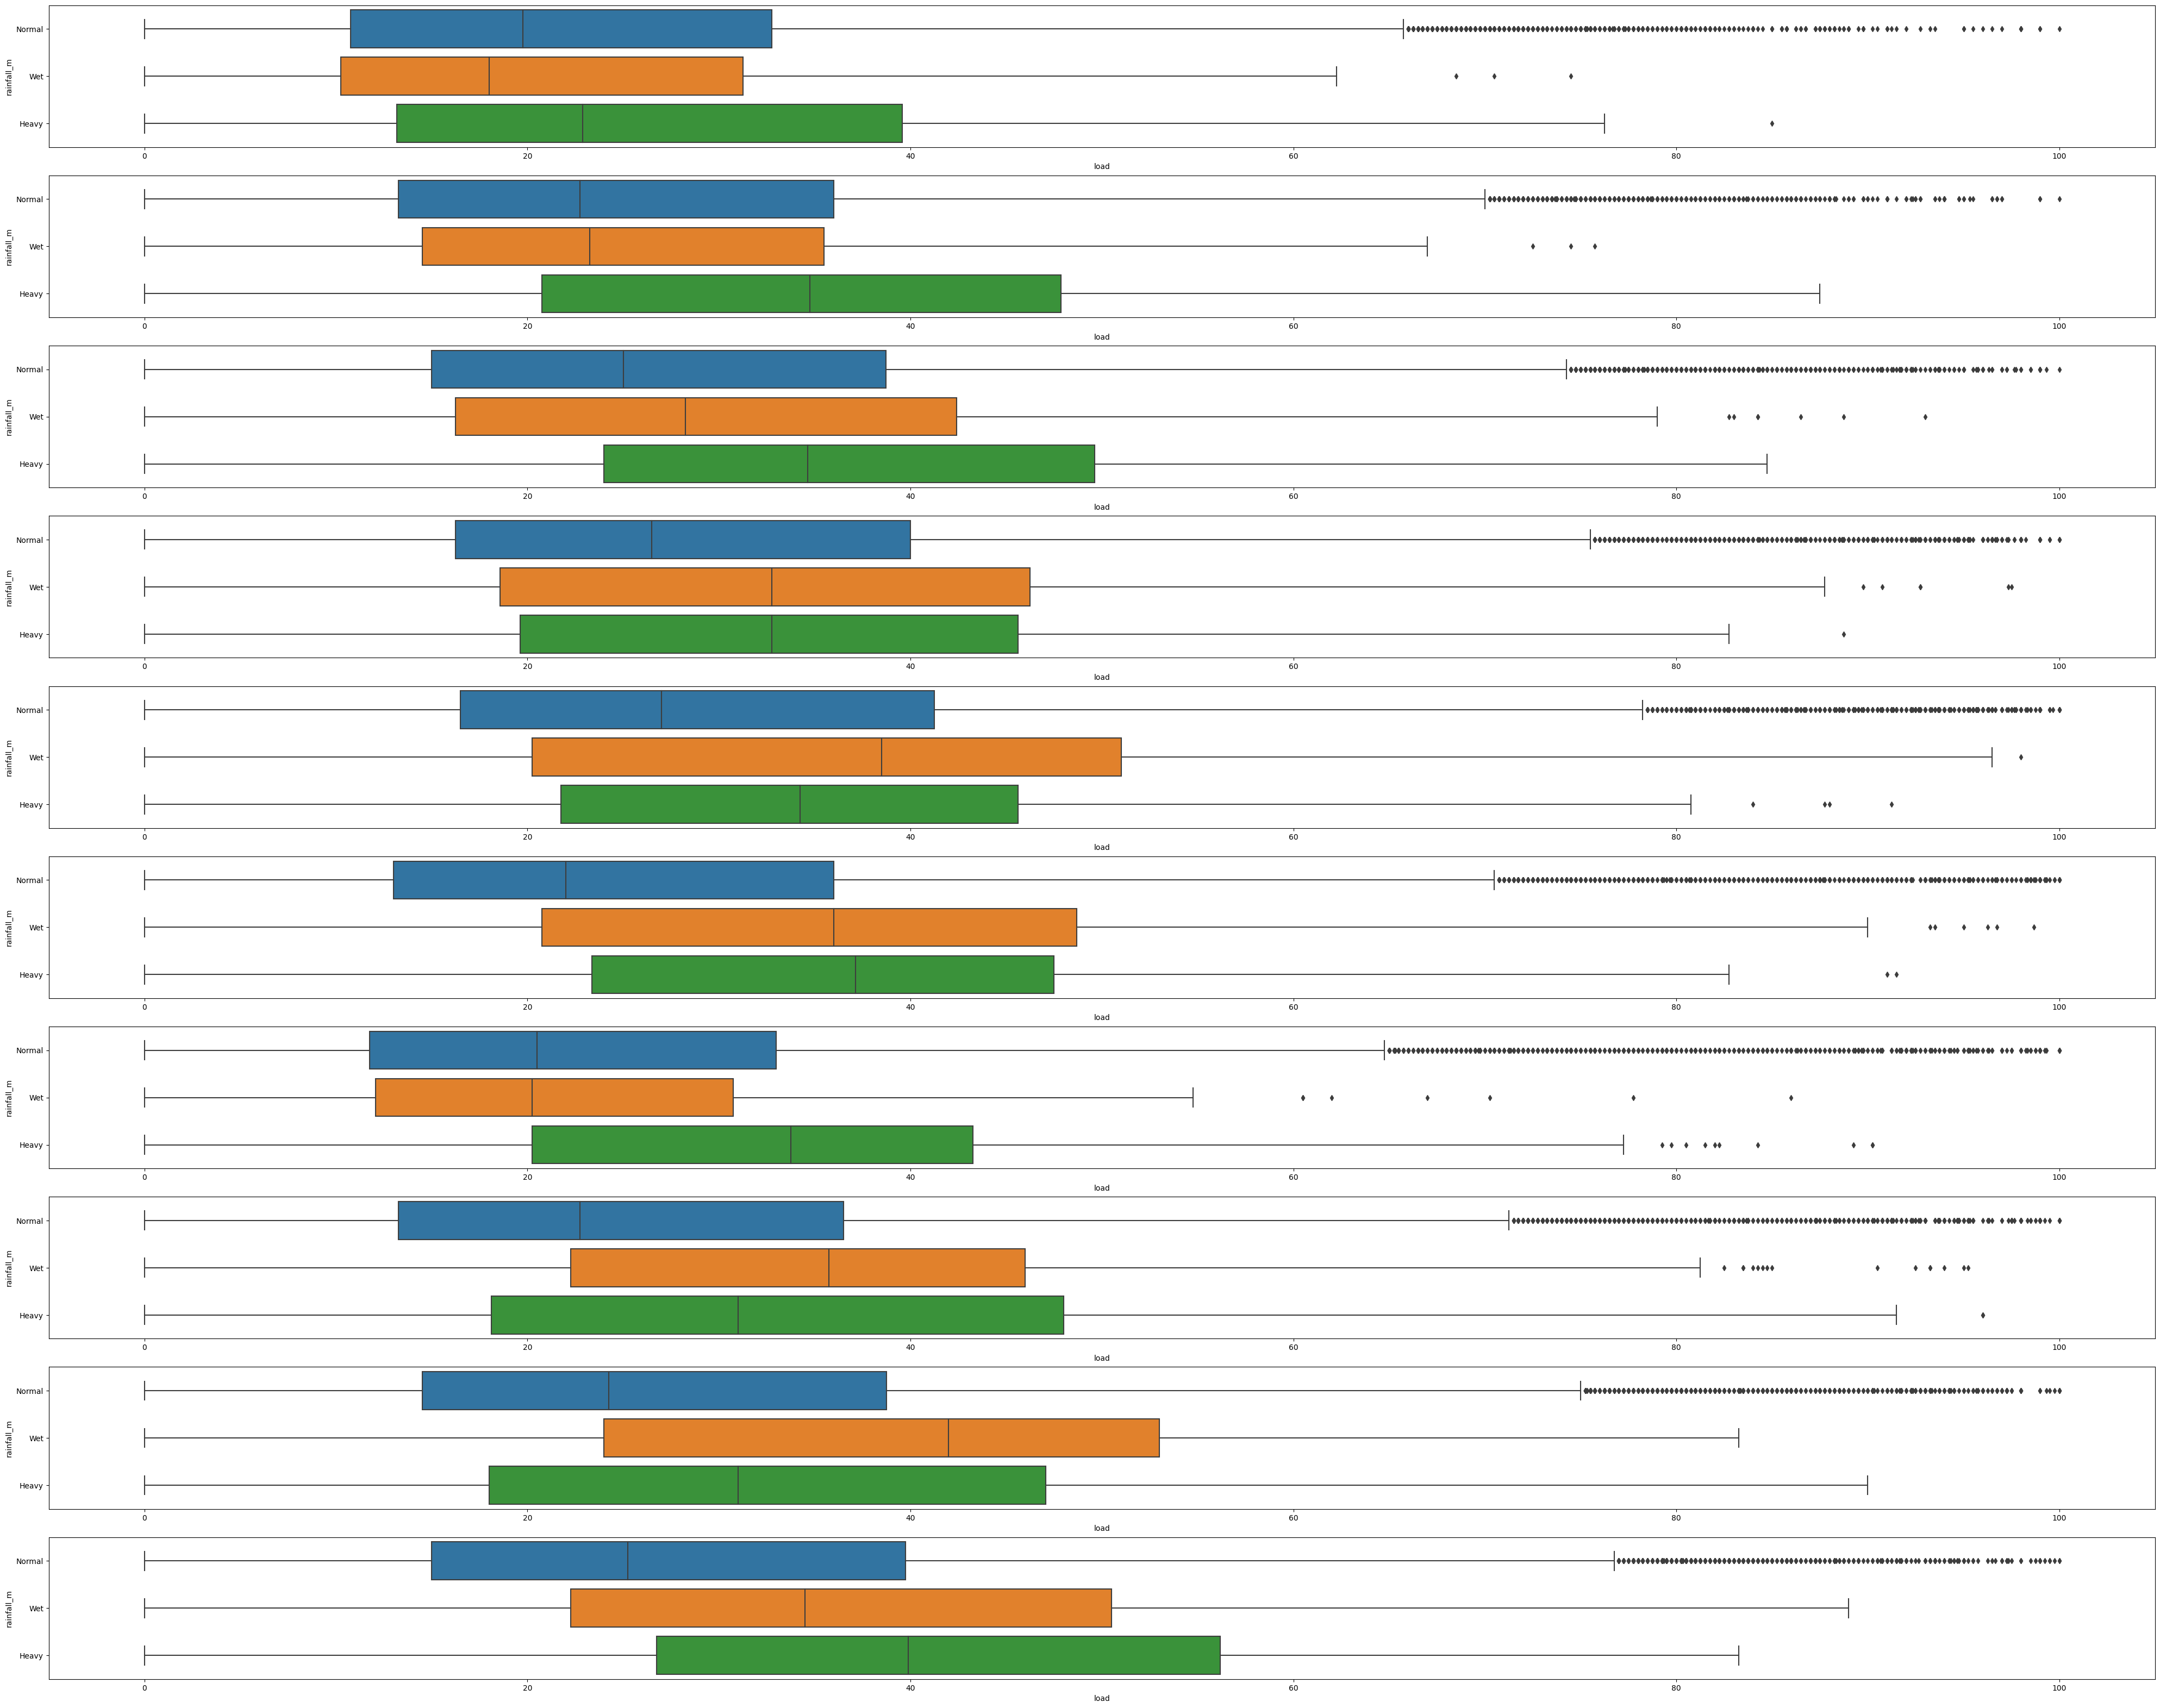

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(10, figsize=(50, 40))
for j, i in enumerate(range(10,20)):
    sns.boxplot(x="load", y="rainfall_m", data=final[final["HOUR"]==i], ax=ax[j])
plt.show()

Podemos comprobar esto en la siguiente tabla donde el incremento de la media en horas de carga con lluvia puede ir del 5% al 14%, lo que concuerda con otros estudios en ciudades europeas [][][]....

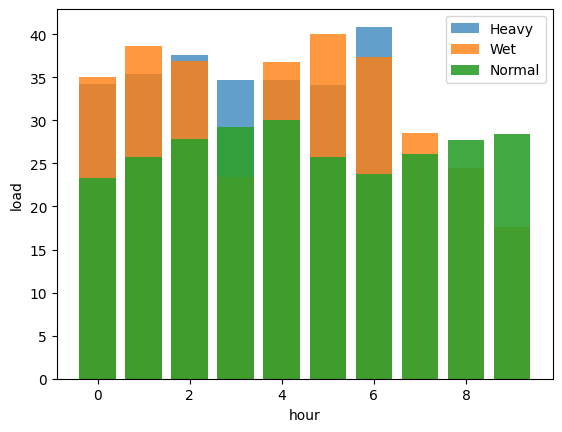

In [104]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

lista = []
j = ["Heavy", "Wet", "Normal"]
for i in j:
    t = final[final["rainfall_m"]== i]
    lista.append(t[["load","HOUR"]].groupby(["HOUR"]).agg({'load': 'mean'}).values[10:20])
    
for t, (i, u) in enumerate(zip(lista,j)):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u, alpha=0.7 + 0.1*t)
plt.legend()
plt.ylabel("load")
plt.xlabel("hour")
plt.show()

Para comprobar que estas diferencias entre grupos son significativas podemos hacer un test anova. Y vemos que en todas las horas existe una gran evidencia de que la carga es diferente entre los distintos tipos de lluvia.

### Temperatura-carga

En esta sección haremos lo mismo que en la anterior sección cambiando la diferencia de temperaturas y la carga segmentada en grupos. En este caso las diferencias no se ven tan claras como en la anterior, se puede cierta tendencia en la temperatura que cuando es menor que la media la carga es menor.

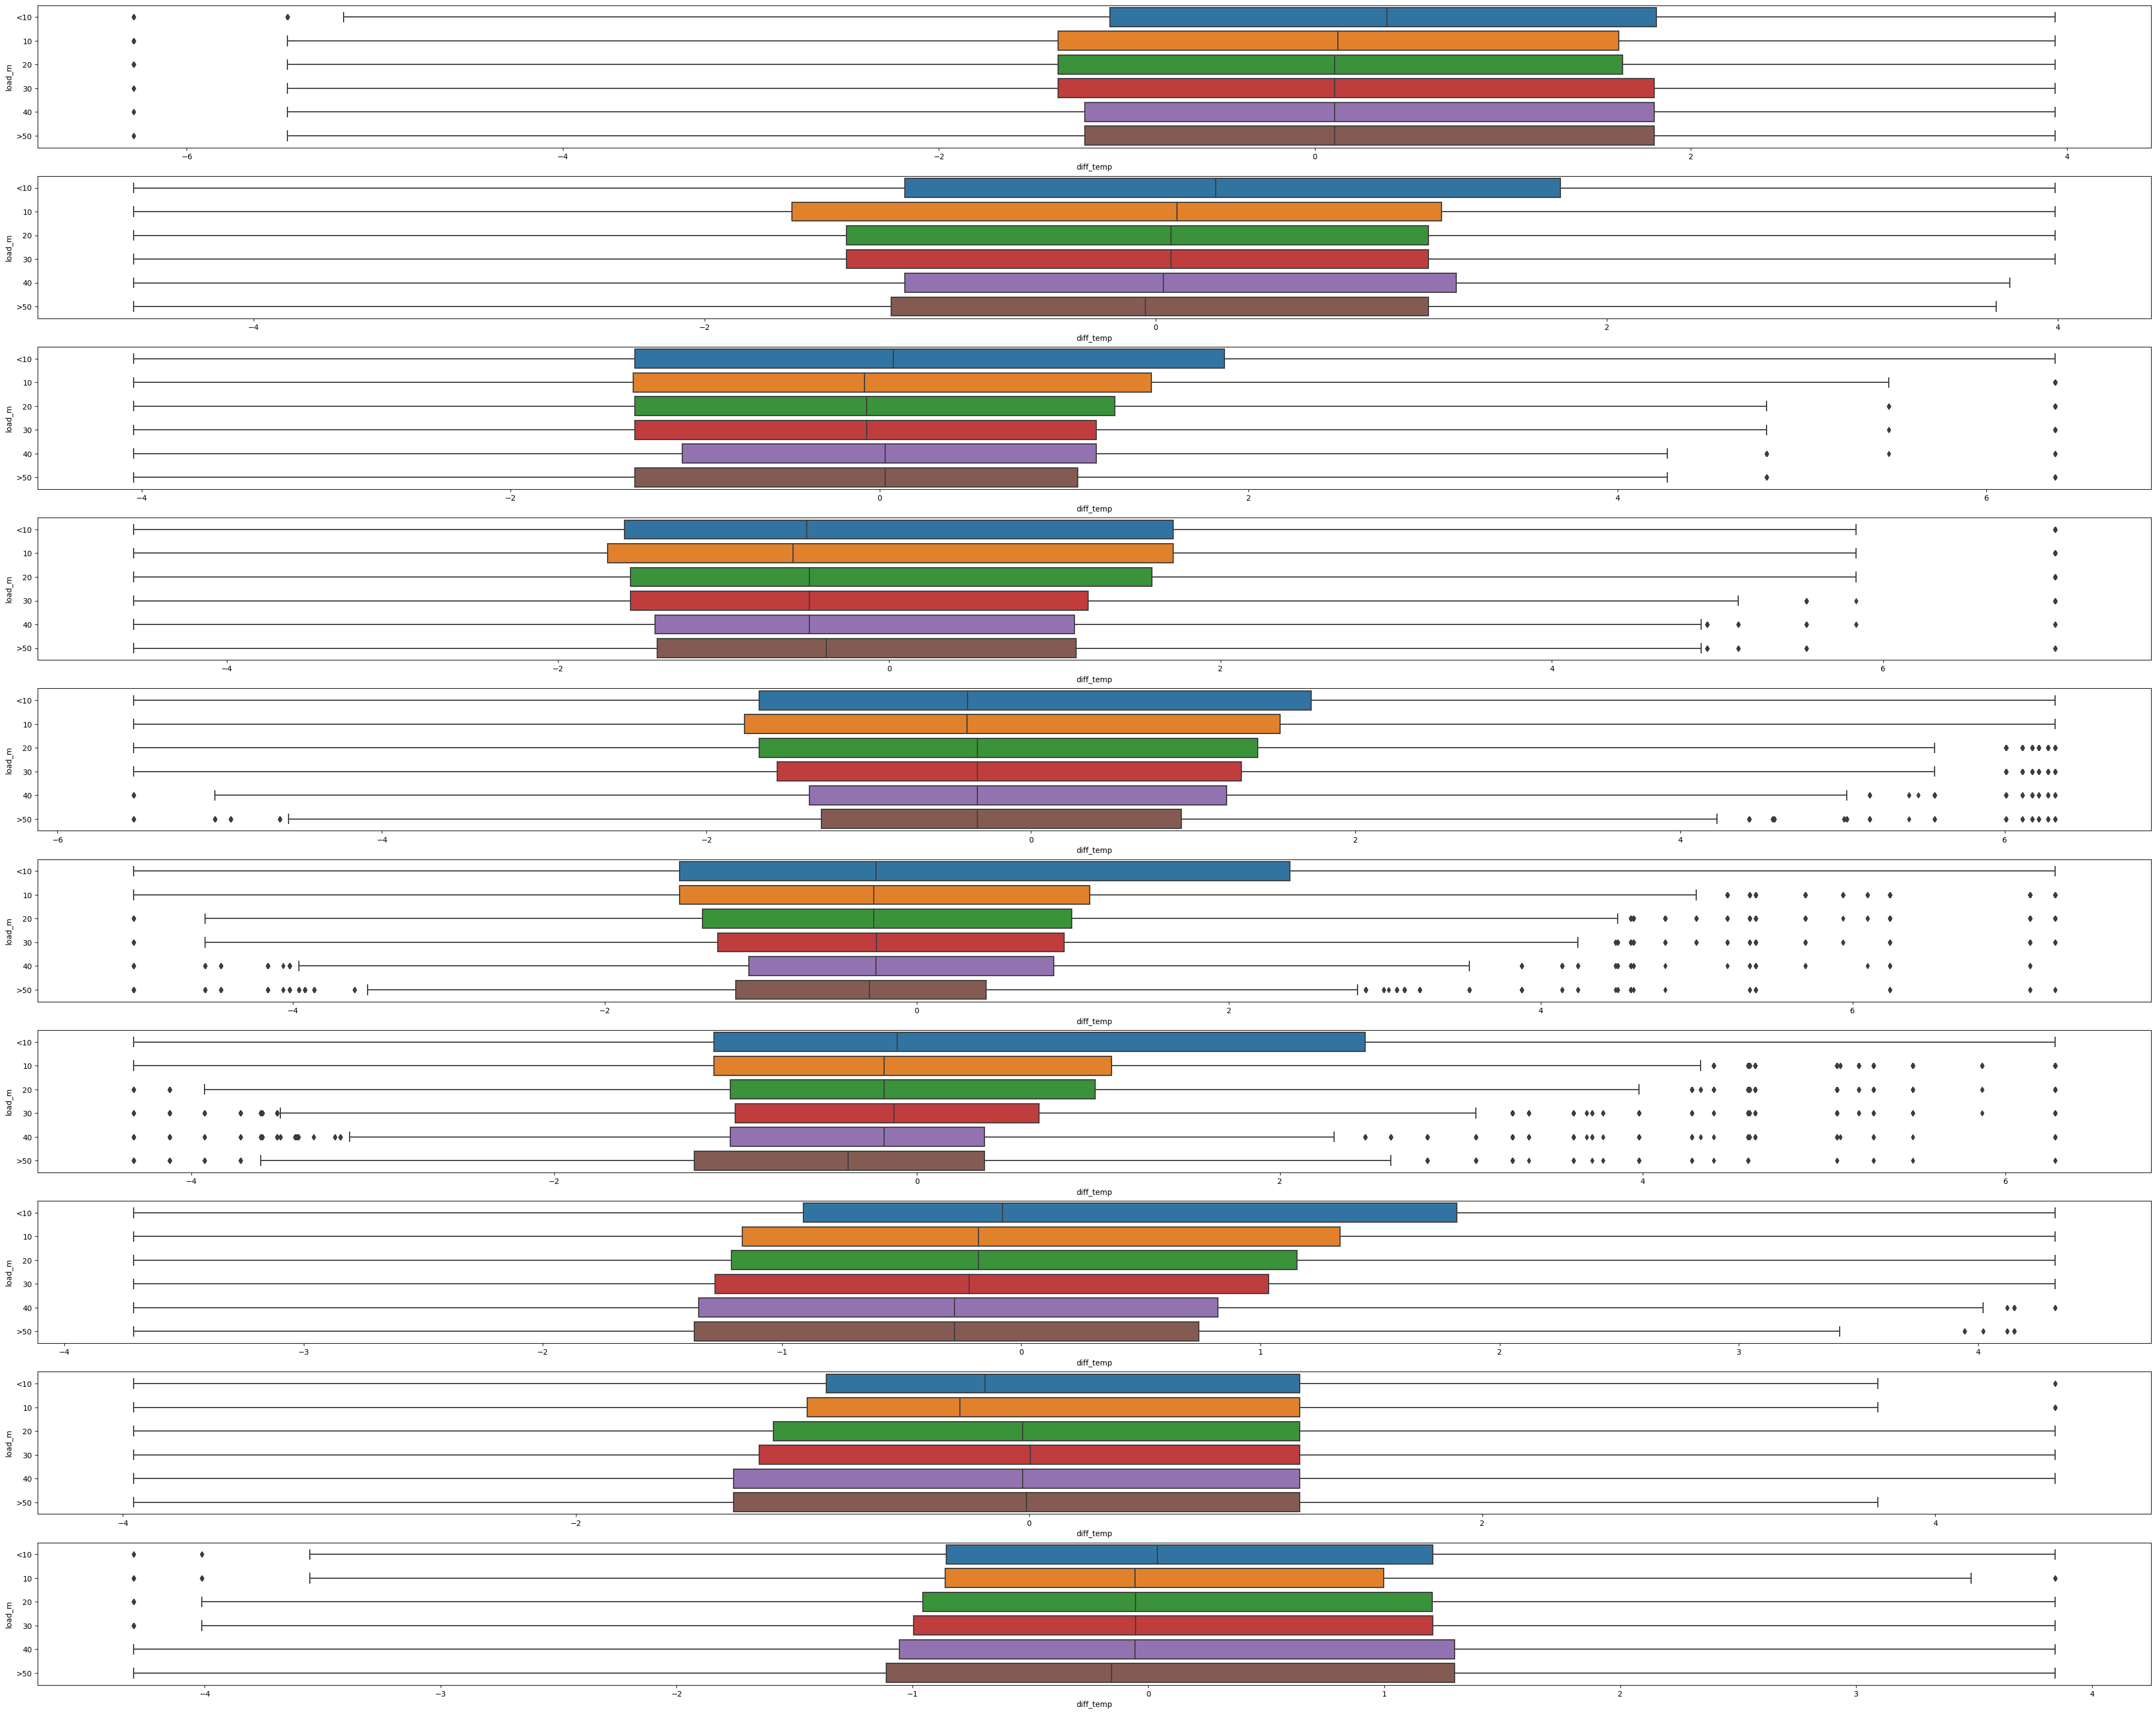

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(10, figsize=(50, 40))
for j, i in enumerate(range(10,20)):
    sns.boxplot(x="diff_temp", y="load_m", data=final[final["HOUR"]==i], ax=ax[j])
plt.show()

En la siguiente tabla queda algo más claro:

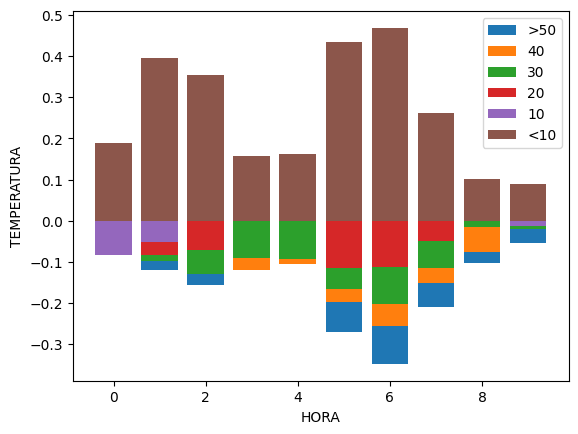

In [110]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

lista = []
j = ["<10", "10","20", "30", "40", ">50"][::-1]
for i in j:
    t = final[final["load_m"]== i]
    lista.append(t[["diff_temp", "HOUR", "load_m"]].groupby(["HOUR", "load_m"]).agg({'diff_temp': 'mean'}).dropna().values[10:20])
    
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("TEMPERATURA")
plt.xlabel("HORA")
plt.show()

In [111]:
for i in range(10,20):
    try:
        model = ols('diff_temp ~ C(load)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('diff_temp ~ C(load)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

HORA  10
                 sum_sq       df         F        PR(>F)
C(load)     2838.780765    439.0  1.599461  3.103402e-14
Residual  138849.550527  34344.0       NaN           NaN
HORA  11
                 sum_sq       df         F        PR(>F)
C(load)     3385.980678    495.0  1.898823  2.309879e-29
Residual  126913.390691  35230.0       NaN           NaN
HORA  12
                 sum_sq       df         F        PR(>F)
C(load)     2972.133099    518.0  1.338445  4.627869e-07
Residual  150862.676323  35192.0       NaN           NaN
HORA  13
                 sum_sq       df        F    PR(>F)
C(load)     2786.302179    478.0  1.03545  0.288052
Residual  200765.494775  35663.0      NaN       NaN
HORA  14
                 sum_sq       df         F    PR(>F)
C(load)     3318.823631    471.0  1.051877  0.212246
Residual  238987.002760  35676.0       NaN       NaN
HORA  15
                 sum_sq       df         F        PR(>F)
C(load)     3934.244360    454.0  1.543926  1.150607e-12
Resi

## Modelo

### Pasar a q:

In [213]:
from sklearn.preprocessing import MinMaxScaler

# Filtrar:
    # 1. Weekday: No se si tenemos weekday. Sería quitar los sabados y domingos (no es muy importante si en q no es facil)
    # 2. Hora: Entre las 9 y las 20
    # 3. Fby por traffic station con Carga >= 40
final = complete[(complete["WEEKDAY"]<5) & (complete["HOUR"]>9) & (complete["HOUR"]<20)].reset_index()
final = final[final.groupby('traffic_station')['load'].transform('mean') >= 40]

# Modificar. Por ahora: 
final["load"]/=100
# Y si puede ser Escalado Min Max a rainfall y temperature: (X_i - min(X)) / (max(X)-min(X))
comp2[["rainfall", "temperature"]] = scaler.fit_transform(comp2.iloc[:, [5,7]])

# Tema indices. El resultado quiero que sea:
    # Estación de tráfico 0: [datos_t0, datos_t1, datos_t2, datos_t3, ...]
    # Estación de tráfico 1: [datos_t0, datos_t1, datos_t2, datos_t3, ...]
    # ...

final = final.set_index(['date'])

# De paso creo ya el train y test. Al final es lo mismo que antes pero por cada estación me quedo 
# los primeros datos para train y luego a partir del 80 para test
# 5: Rainfall, 7: Temperature, 12: Load, 13: Hour, 14: Weekday
train = final.groupby('traffic_station').apply(lambda x: np.array(x[:-80])[:,[5, 7, 12,13,14]].astype(float))
test  = final.groupby('traffic_station').apply(lambda x: np.array(x[-80:])[:,[5, 7, 12,13,14]].astype(float))

# Separar en Windows, Entrada: La estacion, el dataset y los pasos hacia atras.
# La salida: Matriz con shape: Las mediciones que se han hecho en el dataset - los pasos hacia atras, 
                            #  los pasos hacia atras,
                            #  los parametros.
def time_window(traffic_station, dataset, look_back=5):
    data_X,  data_y= [], []
    # Datos estacion
    station_data = dataset[traffic_station]
    
    # Por cada dato en la estacion
    for i in range(len(station_data)-look_back-1):
        # Guardamos en x una matriz con los datos de las últimas 5 rows (Esto es lo complicado)
        data_X.append(station_data[i:(i+look_back)])
        # Guardamos en y el último dato de load. Esto en verdad son los load que van desde look_back + 1 hasta el final.
        data_y.append(station_data[i+look_back+1, 2])

    return np.array(data_X), np.array(data_y)

# Utilizamos la funcion
train_X, train_y = time_window(3403, train)
test_X, test_y = time_window(3403, test)

# COSAS

In [72]:
def create_dataset(dataset, data,look_back=10, timesteps=1):
    dataX, dataY = [], []
    tam = len(dataset[0])
    for j in range(len(dataset)):
        data_X, data_Y = [], []
        for i in range(tam-look_back-1):
            a = np.c_[dataset[j, i:(i+look_back), 0], data[j, i:(i+look_back)]]
            b = dataset[j, (i+look_back):(i+look_back+timesteps), 0]
            if b.shape[0] < timesteps:
                break
            data_X.append(a)
            data_Y.append(b)
        dataX.append(data_X)
        dataY.append(data_Y)
    return np.array(dataX), np.array(dataY)

In [148]:
from sklearn.preprocessing import MinMaxScaler
comp2 = final.set_index(['date'])
scaler = MinMaxScaler()
comp2["traffic_station"]-=1000
comp2[["rainfall", "temperature",'traffic_station',"HOUR", "WEEKDAY"]] = scaler.fit_transform(comp2.iloc[:, [5,7, 11,13,14]])

comp2["load"]/=100
train = comp2.groupby('traffic_station').apply(lambda x: np.array(x[:100])[:,[5, 7, 11, 12,13,14]].astype(float))
test  = comp2.groupby('traffic_station').apply(lambda x: np.array(x[100:180])[:,[5, 7, 11,12,13,14]].astype(float))
train = np.array([x for x in train if len(x)==100])
test = np.array([x for x in test if len(x)==80])

In [156]:
from sklearn.preprocessing import MinMaxScaler
comp2 = final.set_index(['date'])
scaler = MinMaxScaler()
 
comp2["load"]/=100
train = comp2.groupby('traffic_station').apply(lambda x: np.array(x[:100])[:,[5, 7,  12,13,14]].astype(float))
test  = comp2.groupby('traffic_station').apply(lambda x: np.array(x[100:180])[:,[5, 7,  12,13,14]].astype(float))
train = np.array([x for x in train if len(x)==100])
test = np.array([x for x in test if len(x)==80])

train_X, train_y = train[:,:,[0,1,3,4]].reshape(-1,100,4), train[:,:,2].reshape(-1,100,1)
test_X, test_y = test[:,:,[0,1,3,4]].reshape(-1,80,4), test[:,:,2].reshape(-1,80,1)
train_X, train_y = create_dataset(train_y, train_X)
test_X, test_y = create_dataset(test_y, test_X)
train_X, train_y = train_X.reshape(-1,10,5), train_y.reshape(-1,1)
test_X, test_y = test_X.reshape(-1,10,5), test_y.reshape(-1,1)

In [45]:
def create_dataset(val,dataset, data, look_back=5, timesteps=1):
    dataX, dataY = [], []
    tam = len(dataset[0])
    for i in range(tam-look_back-1):
        a = np.c_[dataset[val, i:(i+look_back), 0], data[val,i:(i+look_back)]]
        #a = dataset[50, i:(i+look_back), 0]
        b = dataset[val, (i+look_back):(i+look_back+timesteps), 0]
        if b.shape[0] < timesteps:
            break
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [154]:
train_X, train_y = train[:,:,[0,1,2,4,5]].reshape(-1,100,5), train[:,:,3].reshape(-1,100,1)
test_X, test_y = test[:,:,[0,1,2,4,5]].reshape(-1,80,5), test[:,:,3].reshape(-1,80,1)
train_X, train_y = create_dataset(train_y, train_X)
test_X, test_y = create_dataset(test_y, test_X)
train_X, train_y = train_X.reshape(-1,10,6), train_y.reshape(-1,1)
test_X, test_y = test_X.reshape(-1,10,6), test_y.reshape(-1,1)

IndexError: index 5 is out of bounds for axis 2 with size 5

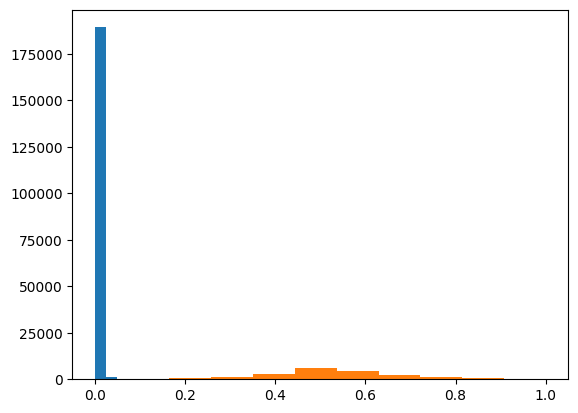

In [150]:
plt.hist(test_X[:,:,1].flatten())
plt.hist(test_y.flatten())
plt.show()

In [159]:
test_X.shape, test_y.shape

((19182, 10, 5), (19182, 1))

Epoch 1/3
398/398 [==============================] - 187s 434ms/step - loss: 0.1471 - val_loss: 0.1214
Epoch 2/3
398/398 [==============================] - 169s 426ms/step - loss: 0.1269 - val_loss: 0.1339
Epoch 3/3
398/398 [==============================] - 170s 427ms/step - loss: 0.1247 - val_loss: 0.1337


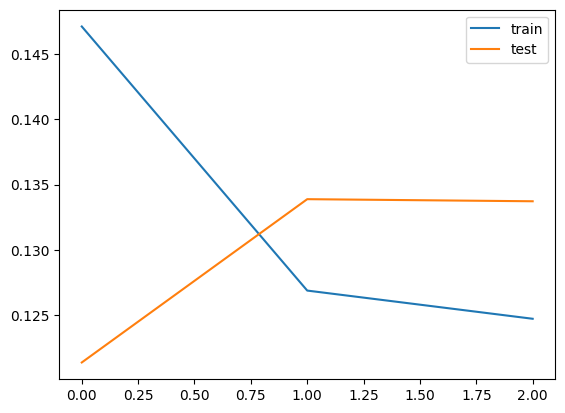

In [164]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
# design network
model = Sequential()

#model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]))
model.add(LSTM(units = 500, return_sequences=True, input_shape=[None,5]))
model.add(LSTM(units = 250,return_sequences=True))
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=3, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)
#history2 = model.fit(train_X2, train_y2, epochs=20, batch_size=64, validation_data=(test_X2, test_y2), verbose=1, shuffle=False)
#history3 = model.fit(train_X3, train_y3, epochs=20, batch_size=64, validation_data=(test_X3, test_y3), verbose=1, shuffle=False)
#history4 = model.fit(train_X4, train_y4, epochs=20, batch_size=64, validation_data=(test_X4, test_y4), verbose=1, shuffle=False)
# plot history
#plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'], label='train')
#plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']+ history4.history['val_loss'], label='test')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

In [487]:
train_X[30000:50000].shape
train_y.shape

(571880, 6)

In [161]:
model.predict(train_X[500:580])

3/3 [==============================] - 1s 50ms/step


array([[0.40076324],
       [0.38436309],
       [0.36381948],
       [0.3602576 ],
       [0.34748444],
       [0.33922336],
       [0.40695578],
       [0.4219818 ],
       [0.42370388],
       [0.43452898],
       [0.45948163],
       [0.44410017],
       [0.43035787],
       [0.44099975],
       [0.44844753],
       [0.45262635],
       [0.46106252],
       [0.4831671 ],
       [0.47451922],
       [0.45628873],
       [0.47217652],
       [0.4559979 ],
       [0.44158038],
       [0.45386323],
       [0.4648386 ],
       [0.45720667],
       [0.46646246],
       [0.4512376 ],
       [0.45821795],
       [0.43142635],
       [0.44541413],
       [0.42853576],
       [0.39121285],
       [0.41775823],
       [0.43279952],
       [0.40803784],
       [0.42642596],
       [0.426658  ],
       [0.42401436],
       [0.46522352],
       [0.46821713],
       [0.41910926],
       [0.4038479 ],
       [0.39930698],
       [0.37166363],
       [0.35621038],
       [0.37339967],
       [0.394

3/3 [==============================] - 0s 44ms/step


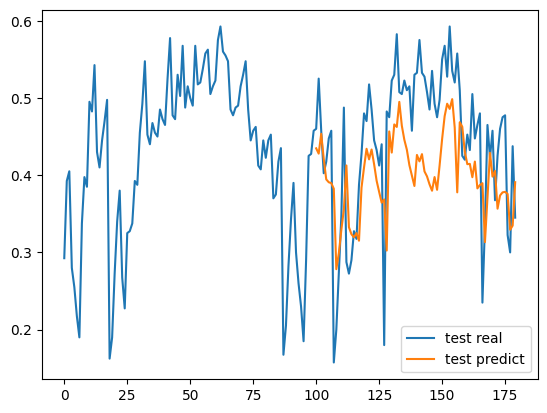

In [163]:
plt.plot(np.r_[train_y[200:300,-1],train_y[300:380,-1]], label='test real')
plt.plot(range(100,180), model.predict(train_X[300:380]), label='test predict')
plt.legend()
plt.show()

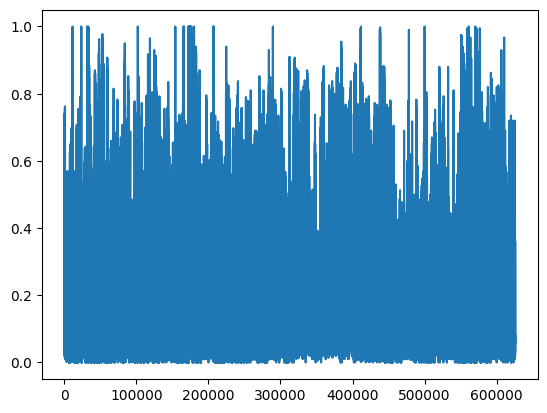

In [470]:
plt.plot(np.r_[train_y[30000:,-1],test_y[:,-1]], label='test real')
plt.show()

3/3 [==============================] - 2s 19ms/step


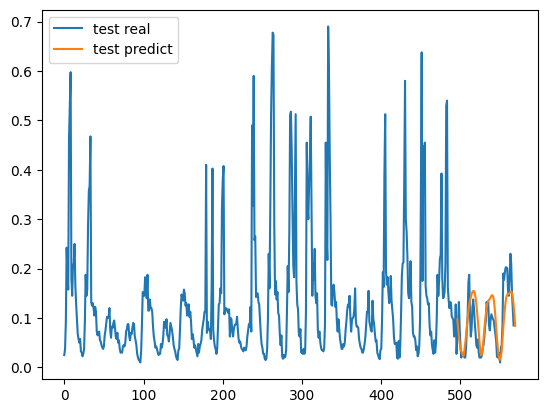

In [384]:
plt.plot(np.r_[train_y[:,-1],test_y[:,-1]], label='test real')
plt.plot(range(496,570), model.predict(test_X).flatten(), label='test predict')
plt.legend()
plt.show()

# Cosas

In [105]:
for i in range(10,20):
    try:
        model = ols('load ~ C(rainfall)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("Hour ", i)
        print(anova_table)
    except:
        print("ERROR HOUR ", i)
model = ols('load ~ C(rainfall)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

Hour  10
                   sum_sq       df          F        PR(>F)
C(rainfall)  9.565132e+04      6.0  60.533806  5.669494e-75
Residual     9.158701e+06  34777.0        NaN           NaN
Hour  11
                   sum_sq       df          F        PR(>F)
C(rainfall)  4.032605e+04      6.0  24.215063  8.799796e-29
Residual     9.913982e+06  35719.0        NaN           NaN
Hour  12
                   sum_sq       df          F        PR(>F)
C(rainfall)  5.077867e+04      6.0  28.428941  4.125247e-34
Residual     1.062885e+07  35704.0        NaN           NaN
Hour  13
                   sum_sq       df          F        PR(>F)
C(rainfall)  2.524776e+04      5.0  16.177487  5.706619e-16
Residual     1.127929e+07  36136.0        NaN           NaN
Hour  14
                   sum_sq       df          F        PR(>F)
C(rainfall)  5.543777e+04      6.0  27.430012  7.574636e-33
Residual     1.217387e+07  36141.0        NaN           NaN
Hour  15
                   sum_sq       df          F 

In [107]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for i in range(24):
    try:
        model = ols('load ~ C(temperature)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('load ~ C(temperature)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

HORA  0
                      sum_sq       df          F         PR(>F)
C(temperature)  1.179438e+05     72.0  17.672672  1.905347e-214
Residual        3.190537e+06  34421.0        NaN            NaN
HORA  1
                      sum_sq       df         F  PR(>F)
C(temperature)  2.101865e+05     83.0  35.82879     0.0
Residual        2.442054e+06  34551.0       NaN     NaN
HORA  2
                      sum_sq       df          F  PR(>F)
C(temperature)  1.569529e+05     82.0  41.187358     0.0
Residual        1.598406e+06  34395.0        NaN     NaN
HORA  3
                      sum_sq       df          F  PR(>F)
C(temperature)  8.719062e+04     77.0  34.464988     0.0
Residual        1.123212e+06  34187.0        NaN     NaN
HORA  4
                       sum_sq       df         F  PR(>F)
C(temperature)   57162.511779     84.0  25.88206     0.0
Residual        895157.118028  34046.0       NaN     NaN
HORA  5
                       sum_sq       df          F         PR(>F)
C(temperature)

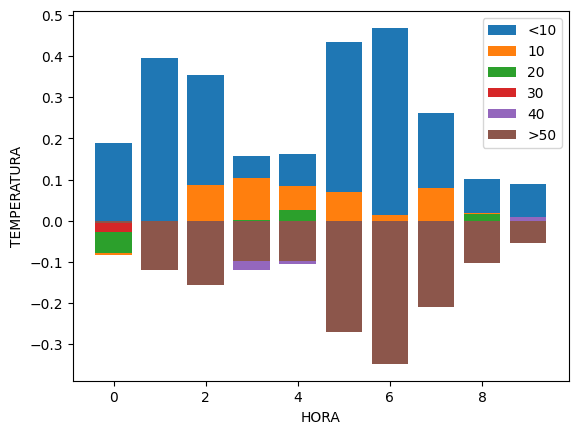

In [67]:
for i, u in zip(lista[::-1],j[::-1]):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("TEMPERATURA")
plt.xlabel("HORA")
plt.show()

In [283]:
lista

[array([[10.18150087],
        [ 6.61469298],
        [ 4.84124424],
        [ 4.593855  ],
        [ 4.18061281],
        [ 4.7403787 ],
        [ 8.37158681],
        [17.84467474],
        [25.94517897],
        [27.5315097 ],
        [30.01408324],
        [36.03826531],
        [30.34688581],
        [23.30853518],
        [16.98646209]]),
 array([[10.61446377],
        [ 7.37880319],
        [ 5.49245347],
        [ 4.58931133],
        [ 4.30648103],
        [ 4.77645053],
        [ 8.02494128],
        [16.44233434],
        [25.23808546],
        [28.53399428],
        [27.74955843],
        [29.77280313],
        [31.49260584],
        [33.11247642],
        [33.88473937],
        [29.7320925 ],
        [28.87651353],
        [33.75189914],
        [35.1680336 ],
        [33.50429894],
        [30.98943318],
        [25.91899602],
        [18.72514024],
        [14.00019801]]),
 array([[11.06279765],
        [ 7.87821043],
        [ 5.8433458 ],
        [ 4.876803  ],
       

In [263]:
final

,date,weather_station,direction,humidity,pressure,rainfall,solar,temperature,wind,Distance,Closest,station,traffic_station,load,WEEKDAY,HOUR,PRECIPITACION_m,temperatura_m,carga_m
24,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,3,0,4,3722,9.25,3,0,Normal,Cold,<10
25,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,3,0,4,3723,2.25,3,0,Normal,Cold,<10
26,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3744,9.25,3,0,Normal,Cold,<10
27,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3745,29.00,3,0,Normal,Cold,20
28,2022-12-01 00:00:00,4,0.0,0.0,0.0,0.0,0.0,7.1,0.0,9,0,4,3746,5.25,3,0,Normal,Cold,<10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840528,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,3858,12.25,4,23,Normal,Cold,10
840529,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4609,12.00,4,23,Normal,Cold,10
840530,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4610,7.50,4,23,Normal,Cold,<10
840531,2022-12-30 23:00:00,35,0.0,64.0,0.0,0.0,0.0,10.4,0.0,3,5,35,4663,11.25,4,23,Normal,Cold,10


In [ ]:
# Entrada
final = df5[(df5["WEEKDAY"]<5) & (df5["carga"]>1)]
#final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])
final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])

#final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 60, 70, 80, 90,np.inf], labels=["None","None_Light","Light", "Light-moderate", "Moderate", "Moderate-heavy", "Heavy", "Heavy-Stop", "Stop"])
final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])


In [ ]:
weather= weather_ori.melt(id_vars=["ESTACION", "MAGNITUD", "FECHA"],
                          value_vars=[x for x in weather_ori.columns if re.match("^H", x)],
                          var_name="HORA")

weather2 = weather_ori.melt( value_vars=[x for x in weather_ori.columns if re.match("^V", x)])


weather["HORA"] = weather["HORA"].str[1:]
weather["HORA"] = pd.to_timedelta(weather['HORA'].astype(int)-1, unit='h')
weather["FECHA"] = weather["FECHA"] + weather["HORA"]


weather= weather[weather2["value"] == "V"]


df1 = weather.assign(MAGNITUD = weather["MAGNITUD"].map({80:"ULTRAVIOLETA",
                                                             81:"VIENTO",
                                                             82:"DIRECCION",
                                                             83:"TEMPERATURA",
                                                             86:"HUMEDAD",
                                                             87:"PRESION",
                                                             88:"SOLAR",
                                                             89:"PRECIPITACION"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") \

# Unirlo a la anterior tabla
weather = pd.concat([weather, df1], axis=1).drop(['MAGNITUD', "value", "HORA"], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.groupby([ "FECHA", "ESTACION"]).sum().reset_index()

In [60]:
import re
import pandas as pd
import numpy as np
import csv 

import pandas as pd
import csv
import numpy as np
from scipy.spatial.distance import cdist
import re
import pandas as pd
import numpy as np
import csv

#################################################################################################################################
##########################################  CARGA DE DATOS ######################################################################
#################################################################################################################################

#Cargar tabla trafico
trafico = pd.read_csv('12-2022.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()

#Cargar tabla meteorológica
weather_ori = pd.read_csv('dic_meteo22.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()

#Carga tablas estaciones y localizaciones
df3 = pd.read_csv('pmed_ubicacion_12-2022.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='utf-8').dropna()
df4 = pd.read_csv('Estaciones_control_datos_meteorologicos.csv', sep = ";", quoting=csv.QUOTE_NONE, encoding='latin-1')

# Cambiar Año/Mes/Dia por fecha
weather_ori = weather_ori.rename(columns={"ANO": "year", "MES": "month", "DIA":"day"})
weather_ori["FECHA"] = pd.to_datetime(weather_ori[["year", "month", "day"]])


# Quitar datos con errores
trafico= trafico[trafico["error"] == "N"]
# String a fecha
trafico['FECHA'] = pd.to_datetime(trafico['fecha'], errors='coerce')
# Eliminar columnas innecesarias
trafico.drop(["tipo_elem", "error", "periodo_integracion", "fecha"], axis=1, inplace=True)
# Agrupar los datos de hora en hora
trafico.resample("1H", on="FECHA").mean()

####################################################################################################################################
###############################  PREPROCESADO METEO ################################################################################
####################################################################################################################################

# Separacion por horas de las H
weather= weather_ori.melt(id_vars=["ESTACION", "MAGNITUD", "FECHA"],
                          value_vars=[x for x in weather_ori.columns if re.match("^H", x)],
                          var_name="HORA")
# Separacion por horas de las V
weather2 = weather_ori.melt( value_vars=[x for x in weather_ori.columns if re.match("^V", x)])

# Entero a Hora
weather["HORA"] = weather["HORA"].str[1:]
weather["HORA"] = pd.to_timedelta(weather['HORA'].astype(int)-1, unit='h')
weather["FECHA"] = weather["FECHA"] + weather["HORA"]

# Seleccion de los valores == V
weather= weather[weather2["value"] == "V"]

# Mapeado de los datos de magnitud con los valores
df1 = weather.assign(MAGNITUD = weather["MAGNITUD"].map({80:"ULTRAVIOLETA",
                                                             81:"VIENTO",
                                                             82:"DIRECCION",
                                                             83:"TEMPERATURA",
                                                             86:"HUMEDAD",
                                                             87:"PRESION",
                                                             88:"SOLAR",
                                                             89:"PRECIPITACION"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") \

# Unirlo a la anterior tabla
weather = pd.concat([weather, df1], axis=1).drop(['MAGNITUD', "value", "HORA"], axis=1)

# Agrupar por fecha, hora y estacion
weather = weather.groupby([ "FECHA", "ESTACION"]).sum().reset_index()

In [153]:
####################################################################################################################################
###############################  PREPROCESADO DISTANCIAS ###########################################################################
####################################################################################################################################

# Calculo de distancias de sensores meteo y trafico
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist
a1 = df4[[ "LATITUD", "LONGITUD"]].rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
a2 = df3[["\"latitud\"", "\"longitud\""]].rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})
#cdist(a1, a2, method= haversine_vector)
unit = Unit.KILOMETERS 
dm = haversine_vector(a1, a2, unit, comb=True)

#distancias["id"] = pd.Series([df3.index[np.argmin(x)] for x in cdist(df4[["LONGITUD", "LATITUD"]], df3[["\"longitud\"","\"latitud\""]])])
distancias = pd.DataFrame.from_dict({'Distance': dm.argmin(axis=1), 'Closest':np.array(dm.min(axis=1), dtype=int)})
distancias = distancias.join(df4[["CÓDIGO_CORTO"]], on="Closest")
distancias = distancias.rename(columns={"CÓDIGO_CORTO": 'ESTACION'})
distancias["id"] = distancias.index


####################################################################################################################################
############################### JUNTAR TABLAS ######################################################################################
####################################################################################################################################

# Juntar tiempo con distancias
df5 = weather.merge(distancias, on="ESTACION")
# Juntar anterior con trafico
df5 = df5.merge(trafico, on=["id", "FECHA"])
# Renombra columna id por estacion_traf
df5.rename(columns={"id": 'estacion_traf'}, inplace=True)
# Añadir dia de la semana y hora
df5["WEEKDAY"] = df5["FECHA"].dt.weekday
df5["HOUR"] = df5["FECHA"].dt.hour

####################################################################################################################################
############################### MODELO SKLEARN #####################################################################################
####################################################################################################################################

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# Entrada
final = df5[(df5["WEEKDAY"]<5) & (df5["carga"]>1)]
#final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])
final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])

#final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 60, 70, 80, 90,np.inf], labels=["None","None_Light","Light", "Light-moderate", "Moderate", "Moderate-heavy", "Heavy", "Heavy-Stop", "Stop"])
final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])

X = final[["HOUR", "WEEKDAY", "DIRECCION",  "HUMEDAD",  "PRECIPITACION",  "PRESION",  "SOLAR",  "TEMPERATURA",  "VIENTO" ]].to_numpy()
# Preprocesado de la entrada
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# Salida
y = final[["carga_m"]].to_numpy().ravel()

# Definicion y entrenamiento del modelo
reg = LogisticRegression(max_iter=10000).fit(X, y)

#Resultado
print(reg.score(X, y))

<ipython-input-153-2901032e1011>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["PRECIPITACION_m"] = pd.cut(final["PRECIPITACION"], [-1, 0.1, 1, np.inf], labels=["Normal","Wet", "Heavy"])
<ipython-input-153-2901032e1011>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["carga_m"] = pd.cut(final["carga"], [-1, 10, 20, 30, 40, 50, np.inf], labels=["<10", "10","20", "30", "40", ">50"])


0.38622995046585684


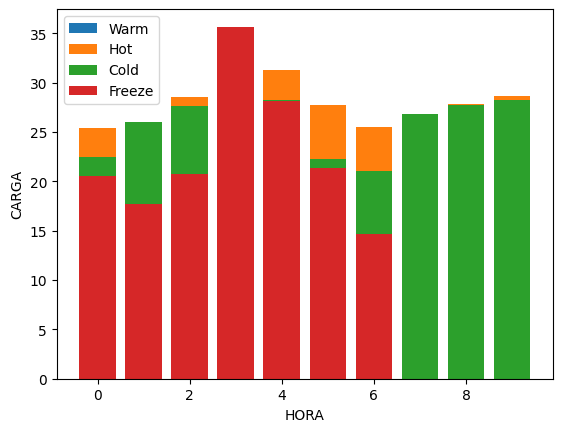

In [108]:
lista = []
j = ["Freeze", "Cold", "Hot","Warm"][::-1]
for i in j:
    t = final[final["temperature_m"]== i]
    lista.append(t[["load","HOUR",  "temperature_m"]].groupby(["HOUR", "temperature_m"]).agg({'load': 'mean'}).dropna().values[10:20])

        
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("CARGA")
plt.xlabel("HORA")
plt.show()

In [48]:
l = final[final["vmed"] > 0]

In [30]:
trafico = pd.read_csv('05-2023.csv', sep = ";", quotechar='"', encoding='utf-8').dropna()
trafico

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2023-05-01 00:00:00,C30,1152,2.0,0,59.0,N,5
1,1001,2023-05-01 00:15:00,C30,780,2.0,0,60.0,N,5
2,1001,2023-05-01 00:30:00,C30,732,2.0,0,63.0,N,5
3,1001,2023-05-01 00:45:00,C30,828,2.0,0,62.0,N,5
4,1001,2023-05-01 01:00:00,C30,612,2.0,0,60.0,N,5
...,...,...,...,...,...,...,...,...,...
12926310,11122,2023-05-31 22:45:00,URB,93,0.0,7,0.0,N,9
12926311,11122,2023-05-31 23:00:00,URB,92,0.0,8,0.0,N,13
12926312,11122,2023-05-31 23:15:00,URB,56,0.0,6,0.0,N,15
12926313,11122,2023-05-31 23:30:00,URB,60,0.0,5,0.0,N,15


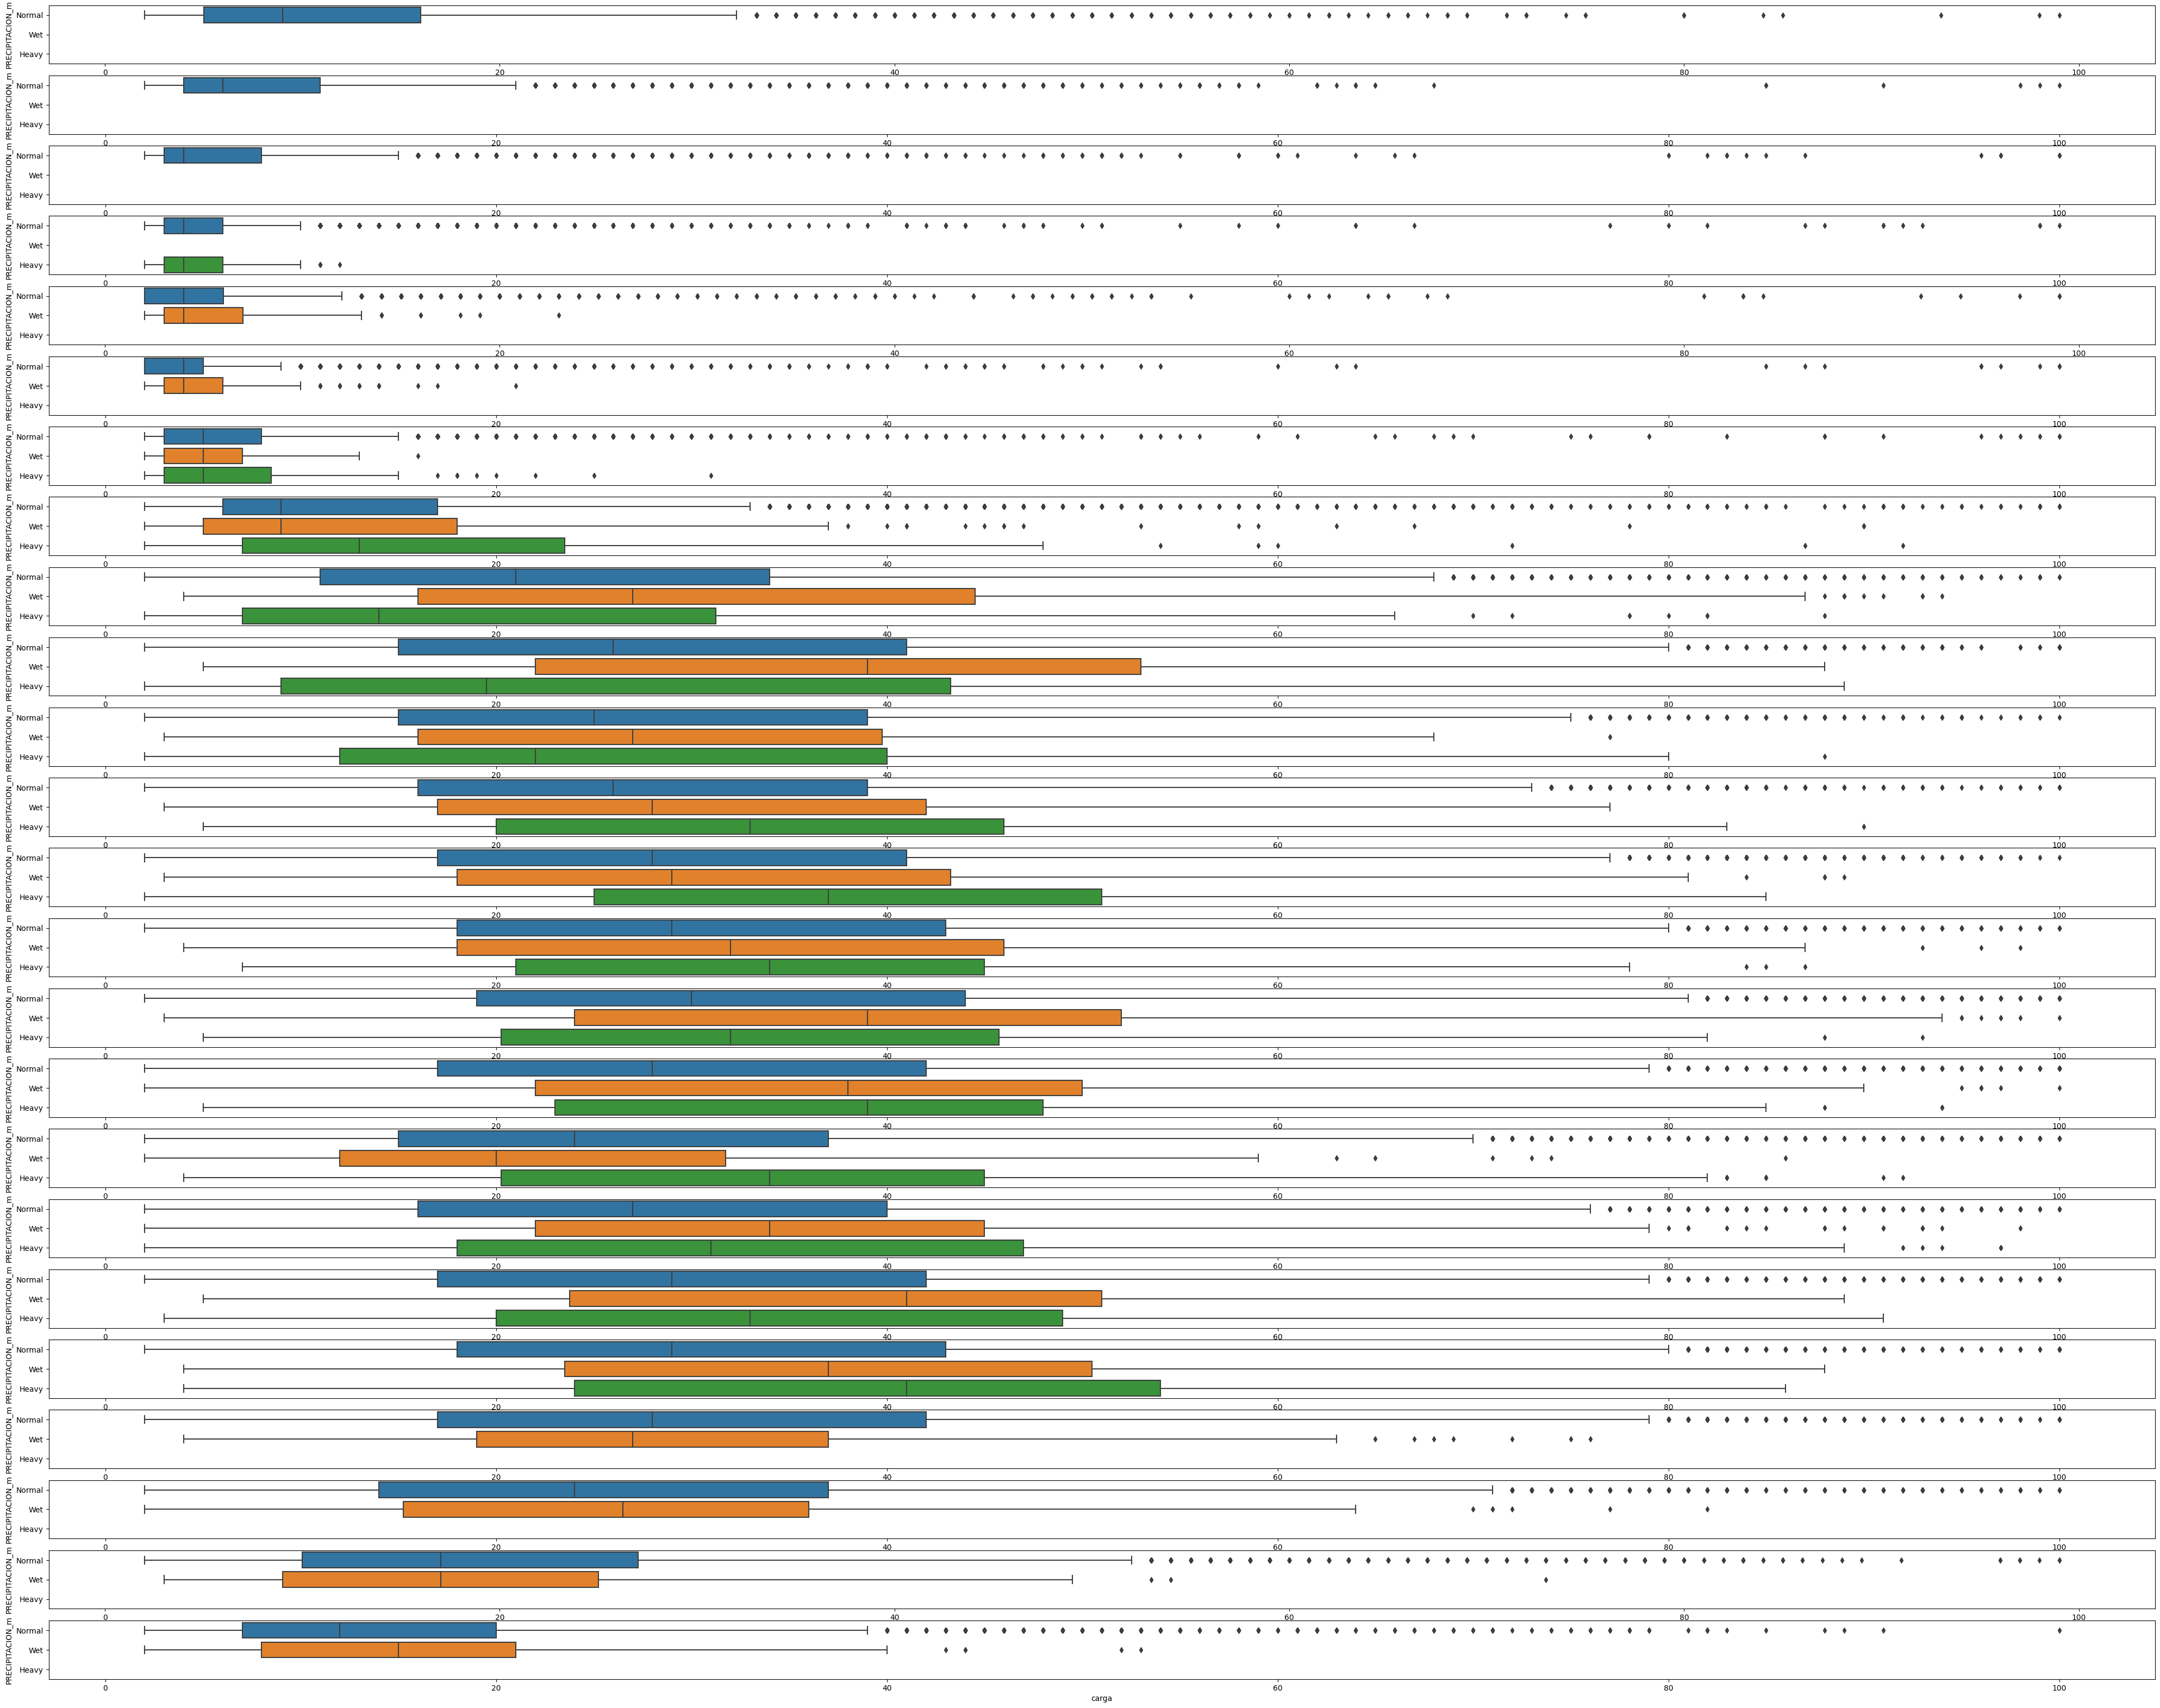

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(24, figsize=(50, 40))
for i in range(24):
    sns.boxplot(x="carga", y="PRECIPITACION_m", data=final[final["HOUR"]==i], ax=ax[i])
#sns.swarmplot(x="carga_v", y="TEMPERATURA", data=final,  ax=ax)
plt.show()

In [99]:
np.unique(final["PRECIPITACION_m"], return_counts=True)

(array(['Heavy', 'Normal', 'Wet'], dtype=object),
 array([  1650, 213083,   2413], dtype=int64))

In [164]:
len(i)

24

HORA  0
                        sum_sq       df         F    PR(>F)
C(PRECIPITACION)  4.651012e+02      1.0  5.448507  0.019594
Residual          1.947643e+06  22816.0       NaN       NaN
ERROR HORA  1
ERROR HORA  2
HORA  3
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)      71.680776      2.0  1.351312  0.258927
Residual          473827.235723  17865.0       NaN       NaN
HORA  4
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)     116.289633      2.0  2.459245  0.085531
Residual          384890.192618  16279.0       NaN       NaN
HORA  5
                         sum_sq       df         F    PR(>F)
C(PRECIPITACION)     171.820476      3.0  2.672861  0.045663
Residual          365815.183681  17072.0       NaN       NaN
HORA  6
                         sum_sq       df         F   PR(>F)
C(PRECIPITACION)      76.502359      2.0  1.090316  0.33613
Residual          714633.703796  20370.0       NaN      NaN
HORA  7
               

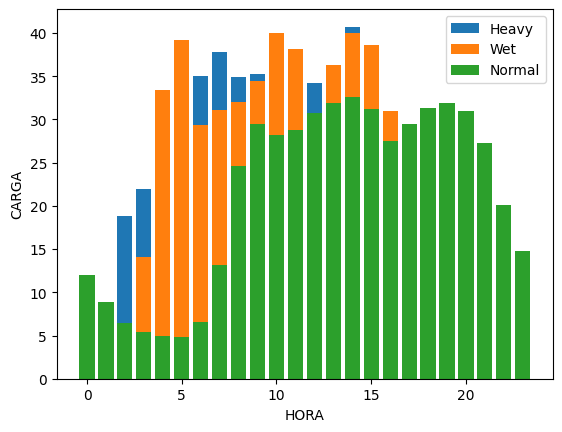

In [181]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


lista = []
j = ["Heavy", "Wet", "Normal"]
for i in j:
    t = final[final["PRECIPITACION_m"]== i]
    lista.append(t[["carga","HOUR",  "PRECIPITACION_m"]].groupby(["HOUR", "PRECIPITACION_m"]).agg({'carga': 'mean'}).dropna().values)

for i in range(24):
    try:
        model = ols('carga ~ C(PRECIPITACION)', data=final[final["HOUR"]==i]).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("HORA ", i)
        print(anova_table)
    except:
        print("ERROR HORA ", i)
model = ols('carga ~ C(PRECIPITACION)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
    
for i, u in zip(lista,j):
    plt.bar(np.arange(len(i)), i.reshape(-1), label=u)
plt.legend()
plt.ylabel("CARGA")
plt.xlabel("HORA")
plt.show()

In [121]:
final[["carga","HOUR",  "PRECIPITACION_m"]].groupby(["PRECIPITACION_m"]).count()["carga"].values

array([213083,   2413,   1650], dtype=int64)

In [146]:
state_pcts

carga
HOUR HOUR PRECIPITACION_m           
9    9    Normal           30.592622
          Wet              40.742444
          Heavy            28.664934
10   10   Normal           33.159813
          Wet              34.597833
          Heavy            32.242354
11   11   Normal           30.365575
          Wet              32.792100
          Heavy            36.842325
12   12   Normal           30.527473
          Wet              31.836128
          Heavy            37.636399
13   13   Normal           31.510195
          Wet              34.005886
          Heavy            34.483919
14   14   Normal           30.239495
          Wet              37.058320
          Heavy            32.702185
15   15   Normal           28.919655
          Wet              35.417105
          Heavy            35.663240
16   16   Normal           31.997313
          Wet              27.253762
          Heavy            40.748925
17   17   Normal           29.501720
          Wet              36.330094
          Heavy            34.168186

In [145]:
state_pcts = a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

<ipython-input-145-7744e3281638>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  state_pcts = a.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))


In [91]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('TEMPERATURA ~ C(carga_m)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(carga_m),8.757586e+02,5.0,24.632273,6.825506e-25
Residual,1.544009e+06,217140.0,NaN,NaN


In [87]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('PRECIPITACION ~ C(carga_m)', data=final).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(carga_m),6.16623,5.0,24.311517,1.492107e-24
Residual,11014.82223,217140.0,NaN,NaN


In [ ]:
import pingouin as pg
pg.pairwise_ttests(
    dv      = 'carga',
    within  = 'PRECIPITACION_m',
    subject = 'TEMPERATURA',
    padjust = 'holm',
    data    = final
)

C:\Users\marco\anaconda3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


In [52]:
pip install pingouin

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\anaconda3\python.exe -m pip install --upgrade pip' command.


  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7034 sha256=1c082ebb3aab9bf2e6984a67940f08fc21aeecba3b088be05018ba66e78b344a
  Stored in directory: c:\users\marco\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [48]:
final["TEMPERATURA"] = final["TEMPERATURA"].astype(int)

<ipython-input-48-29c65e1009f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["TEMPERATURA"] = final["TEMPERATURA"].astype(int)


In [ ]:
weather["PRECIPITACION_m"] = pd.cut(weather["PRECIPITACION"], [-1, 0.01, 0.5, 4, np.inf], labels=["None","Light","Moderate", "Heavy"])

In [ ]:
weather["PRECIPITACION"]

In [ ]:
myDictionary

In [ ]:
import matplotlib.pyplot as plt

unique, counts = np.unique(final["PRECIPITACION_m"], return_counts=True)
myDictionary = dict(zip(unique, counts))
plt.bar(myDictionary.keys(), myDictionary.values(), color='g')
plt.show()

In [ ]:
import seaborn as sns
ax = sns.barplot(data=wheather, x='variable', y='value', hue='card_name')
plt.show()

In [ ]:
function measure(lat1, lon1, lat2, lon2){  // generally used geo measurement function
    var R = 6378.137; // Radius of earth in KM
    var dLat = lat2 * Math.PI / 180 - lat1 * Math.PI / 180;
    var dLon = lon2 * Math.PI / 180 - lon1 * Math.PI / 180;
    var a = Math.sin(dLat/2) * Math.sin(dLat/2) +
    Math.cos(lat1 * Math.PI / 180) * Math.cos(lat2 * Math.PI / 180) *
    Math.sin(dLon/2) * Math.sin(dLon/2);
    var c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));
    var d = R * c;
    return d * 1000; // meters
}

r = 6378.137
dLat = lat2 * Math.PI / 180 - lat1 * Math.PI / 180

In [ ]:

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

In [10]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\marco\anaconda3\python.exe -m pip install --upgrade pip' command.


In [20]:
df4[["LONGITUD", "LATITUD"]].to_numpy()[0]

array([-3.7122567, 40.4238823])

In [30]:
haversine(df4[["LONGITUD", "LATITUD"]].to_numpy()[0], df4[["LONGITUD", "LATITUD"]].to_numpy()[21])

3.5484393496954305

In [35]:
df4[["LONGITUD", "LATITUD"]]

,LONGITUD,LATITUD
0,-3.712257,40.423882
1,-3.682316,40.421553
2,-3.639242,40.440046
3,-3.731836,40.394782
4,-3.747345,40.419358
5,-3.703166,40.419209
6,-3.645310,40.407952
7,-3.707130,40.445544
8,-3.711536,40.478232
9,-3.612139,40.373012


In [ ]:
def test(xs, ys, radius=1):
    return cdist(xs, ys, metric=lambda x, y, radius=radius: distanceMetric(x, y, radius))

In [46]:
df4.to_numpy()

array([[ 2.80790040e+07,  4.00000000e+00, -3.71225670e+00,
         4.04238823e+01],
       [ 2.80790080e+07,  8.00000000e+00, -3.68231580e+00,
         4.04215533e+01],
       [ 2.80790160e+07,  1.60000000e+01, -3.63924220e+00,
         4.04400457e+01],
       [ 2.80790180e+07,  1.80000000e+01, -3.73183560e+00,
         4.03947825e+01],
       [ 2.80790240e+07,  2.40000000e+01, -3.74734450e+00,
         4.04193577e+01],
       [ 2.80790350e+07,  3.50000000e+01, -3.70316620e+00,
         4.04192091e+01],
       [ 2.80790360e+07,  3.60000000e+01, -3.64531040e+00,
         4.04079517e+01],
       [ 2.80790380e+07,  3.80000000e+01, -3.70713030e+00,
         4.04455439e+01],
       [ 2.80790390e+07,  3.90000000e+01, -3.71153640e+00,
         4.04782322e+01],
       [ 2.80790540e+07,  5.40000000e+01, -3.61213940e+00,
         4.03730118e+01],
       [ 2.80790560e+07,  5.60000000e+01, -3.71876790e+00,
         4.03850336e+01],
       [ 2.80790580e+07,  5.80000000e+01, -3.77461010e+00,
      

In [52]:
from haversine import haversine_vector, Unit
from scipy.spatial.distance import cdist
a1 = df4[[ "LATITUD", "LONGITUD"]].rename(columns={"LATITUD": 'Latitude', "LONGITUD":"Longitude"})
a2 = df3[["\"latitud\"", "\"longitud\""]].rename(columns={"\"latitud\"": 'Latitude', "\"longitud\"":"Longitude"})
#cdist(a1, a2, method= haversine_vector)
unit = Unit.KILOMETERS 
dm = haversine_vector(a1, a2, unit, comb=True)

closest = dm.argmin(axis=1)
distances = dm.min(axis=1)

In [60]:
unique, counts = np.unique(closest, return_counts=True)
for i, v in zip(unique,counts):
    print(i,": ",v)

0 :  134
1 :  68
2 :  467
3 :  350
4 :  86
5 :  65
6 :  156
7 :  332
8 :  413
9 :  84
10 :  230
11 :  9
12 :  157
13 :  136
14 :  107
15 :  122
16 :  131
17 :  595
18 :  157
19 :  136
20 :  127
21 :  200
22 :  216
24 :  261


In [61]:
np.mean(distances)

1.556835943963195

In [42]:
df4[["LONGITUD", "LATITUD"]]

,LONGITUD,LATITUD
0,-3.712257,40.423882
1,-3.682316,40.421553
2,-3.639242,40.440046
3,-3.731836,40.394782
4,-3.747345,40.419358
5,-3.703166,40.419209
6,-3.645310,40.407952
7,-3.707130,40.445544
8,-3.711536,40.478232
9,-3.612139,40.373012
